In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.datasets import cifar10
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


In [3]:
def graph(history):
    epoklar = range(1,len(history["loss"])+1)
    
    plt.plot(epoklar,history["loss"],label="Training Loss")
    plt.plot(epoklar,history["val_loss"],label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.plot(epoklar,history["acc"],label="Training Accuracy")
    plt.plot(epoklar,history["val_acc"],label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [4]:
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 7s 0us/step


In [5]:
def resize(images):
    yeni = np.zeros((images.shape[0],96,96,3),dtype=np.float32)
    for i in range(len(images)):
        yeni[i] = cv2.resize(images[i,:,:,:],(96,96))
    return yeni

In [6]:
train_images = resize(train_images)
test_images = resize(test_images)

In [7]:
train_images.shape

(50000, 96, 96, 3)

In [8]:
train_labels.shape

(50000, 1)

In [9]:
numberOfClass = len(np.unique(train_labels))
numberOfClass

10

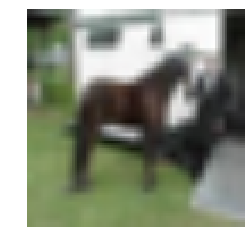

In [10]:
plt.imshow(test_images[20].astype(np.uint8))
plt.axis("off")
plt.show()

In [11]:
#one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [12]:
x_train = train_images[:35000]
y_train = train_labels[:35000]

x_valid = train_images[35000:]
y_valid = train_labels[35000:]

x_test = test_images
y_test = test_labels

In [13]:
#data augmentation and normalize images with using ImageDataGenerator
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

valid_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [14]:
batch_size = 256
epoch = 30
size = x_train.shape[1:]

In [15]:
train_generator = train_datagen.flow(x_train,y_train,batch_size=batch_size)
valid_generator = valid_datagen.flow(x_valid,y_valid,batch_size=batch_size)
test_generator = test_datagen.flow(x_test,y_test,batch_size=batch_size)

# Feature Extraction

Step 1 - Load pre-trained model and freeze

Step 2 - Create new model and add the frozen pretrained model in this model

Step 3 - Add dense layers

Step 4 - Train Model

In [16]:
vgg16 = VGG16(weights="imagenet",include_top=False,input_shape=size)

58892288/58889256 [==============================] - 2s 0us/step


In [17]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

**Load Pre-trained Model**

* We are select include_top = False. Because we are don't want dense layers.

* This Model coming with trained weights on imagenet

In [18]:
#create new model and add pretrained model in this model
model = models.Sequential()
for i in range(len(vgg16.layers)):
    model.add(vgg16.layers[i])

for i in range(len(model.layers)): #freeze pretrained model
    model.layers[i].trainable = False

#add new layers your model
model.add(layers.Flatten())
model.add(layers.Dropout(0.40))
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(numberOfClass,activation="softmax"))

In [19]:
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",
              metrics=["acc"])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

In [21]:
(4608*256 + 256) + (256*10 + 10)

1182474

Now we have 1,182,474 trainable params.

In [22]:
history = model.fit_generator(generator=train_generator,
                steps_per_epoch=len(train_generator),epochs=epoch,
                validation_data=valid_generator,
                validation_steps=len(valid_generator))

Epoch 1/30
137/137 [==============================] - 84s 611ms/step - loss: 1.6543 - acc: 0.4538 - val_loss: 1.0244 - val_acc: 0.6143
Epoch 2/30
137/137 [==============================] - 76s 554ms/step - loss: 1.2512 - acc: 0.5645 - val_loss: 0.9445 - val_acc: 0.6529
Epoch 3/30
137/137 [==============================] - 76s 557ms/step - loss: 1.1745 - acc: 0.5893 - val_loss: 0.8335 - val_acc: 0.6775
Epoch 4/30
137/137 [==============================] - 77s 560ms/step - loss: 1.1277 - acc: 0.6057 - val_loss: 0.9950 - val_acc: 0.6687
Epoch 5/30
137/137 [==============================] - 76s 558ms/step - loss: 1.0958 - acc: 0.6170 - val_loss: 0.8558 - val_acc: 0.6991
Epoch 6/30
137/137 [==============================] - 76s 557ms/step - loss: 1.0624 - acc: 0.6261 - val_loss: 0.9200 - val_acc: 0.6995
Epoch 7/30
137/137 [==============================] - 76s 555ms/step - loss: 1.0563 - acc: 0.6303 - val_loss: 0.7573 - val_acc: 0.7047
Epoch 8/30
137/137 [==============================] - 7

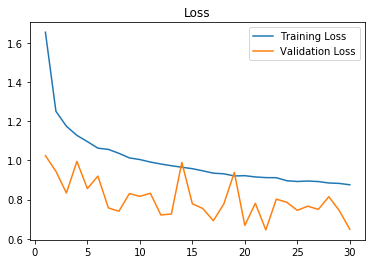

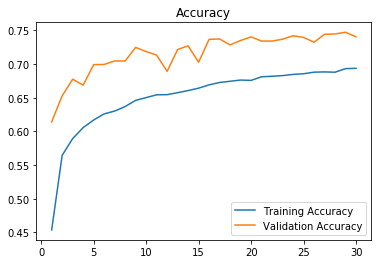

In [23]:
graph(history.history)

In [24]:
loss,acc = model.evaluate_generator(test_generator,
                        steps=len(test_generator))

In [25]:
print("Test Accuracy =",acc)

Test Accuracy = 0.7329999804496765


# Fine Tunning

Step 1 - Take the Feature Extraction(We are did this step)

Step 2 - Select layers to Fine Tunning

Step 3 - Train Model


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

In [27]:
#select after blocks block5_conv1 to fine tunnig
trnable = False
for i in model.layers:
    if i.name == "block5_conv1":
        trnable = True
    i.trainable = trnable

In [28]:
from keras import optimizers

In [29]:
#compile model with very low learning rate
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
        loss="categorical_crossentropy",metrics=["acc"])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

Now we have 8,261,898 trainable params

In [31]:
batch_size = 256
epoch = 50

In [32]:
history = model.fit_generator(generator=train_generator,
                steps_per_epoch=len(train_generator),epochs=epoch,
                validation_data=valid_generator,
                validation_steps=len(valid_generator))

Epoch 1/50
137/137 [==============================] - 80s 587ms/step - loss: 0.8133 - acc: 0.7138 - val_loss: 0.8239 - val_acc: 0.7631
Epoch 2/50
137/137 [==============================] - 77s 559ms/step - loss: 0.7637 - acc: 0.7346 - val_loss: 0.6659 - val_acc: 0.7805
Epoch 3/50
137/137 [==============================] - 77s 559ms/step - loss: 0.7379 - acc: 0.7429 - val_loss: 0.6452 - val_acc: 0.7847
Epoch 4/50
137/137 [==============================] - 77s 562ms/step - loss: 0.7163 - acc: 0.7491 - val_loss: 0.5255 - val_acc: 0.7921
Epoch 5/50
137/137 [==============================] - 76s 555ms/step - loss: 0.6925 - acc: 0.7589 - val_loss: 0.4507 - val_acc: 0.7963
Epoch 6/50
137/137 [==============================] - 76s 558ms/step - loss: 0.6761 - acc: 0.7644 - val_loss: 0.4654 - val_acc: 0.8004
Epoch 7/50
137/137 [==============================] - 77s 560ms/step - loss: 0.6642 - acc: 0.7672 - val_loss: 0.6220 - val_acc: 0.8013
Epoch 8/50
137/137 [==============================] - 7

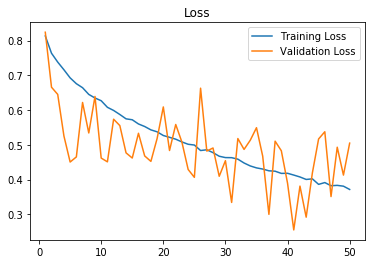

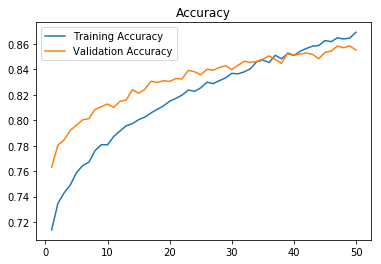

In [33]:
graph(history.history)

In [34]:
loss,acc = model.evaluate_generator(test_generator,
                            steps=len(test_generator))

In [35]:
print("Test Accuracy =",acc)

Test Accuracy = 0.8458999991416931
